Figure 1. Preliminary simulation of the dispersal of coral reef fish released in Florida. Cyan and red lines represent trajectories of fish that settled and did not settle, respectively. We track the fish from every release date to 78 days, and any fish within 2km of original release locations after 31 days are deemed "settled".

Simulating two different periods of release dates:

1. 17 April 2007 - 11 Sept 2007
2. 6 April 2008 - 30 Sept 2008

Time step is every 6 hours

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
from datetime import timedelta
import datetime
import numpy as np
from scipy.io import netcdf
from netCDF4 import Dataset
import pandas as pd

from mpl_toolkits.basemap import Basemap

import cartoframes

# import urllib2
# import StringIO
# import csv
import numpy as np
# import scipy.interpolate
import matplotlib.pyplot as plt
# import pickle as pickle

# first doing 2007
filenames = {'U': "florida_currents/2008_currents/*zu.nc",
             'V': "florida_currents/2008_currents/*zv.nc"}

In [2]:
# Check to see what time, depth, lat, and lon are called from a single file
pfile = Dataset('fl/2008_currents/902_archv.2008_191_06_3zu.nc', 'r')
pfile.dimensions

IOError: [Errno 2] No such file or directory: 'florida_currents/2008_currents/902_archv.2008_191_06_3zu.nc'

In [ ]:
d = np.array(pfile.variables['precip'], dtype=type(nc.variables))

In [93]:
type(pfile.variables)

collections.OrderedDict

In [7]:
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'time': 'MT','depth': 'Depth',
              'lat': 'Latitude',
              'lon': 'Longitude'}

In [39]:
# if something wrong with time of fields... use allow_time_extrapolation = True
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)

In [40]:
3345148800.0 - 3345192000.0

-43200.0

In [11]:
# Number of simulations
print(datetime.date(2007,9,11) - datetime.date(2007,4,17))
print(datetime.date(2008,9,30) - datetime.date(2008,4,6))

147 days, 0:00:00
177 days, 0:00:00


In [57]:
fieldset.U.grid.time[0]

3345148800.0

In [50]:
datetime.date(1900,12,31) + datetime.timedelta(seconds = 3345148800)

datetime.date(2007, 1, 1)

In [74]:
dt = datetime.date(2007,4,17) - datetime.date(2007, 1, 1)
# how many 6 hour intervals from january 1 2007 to april 17 2007?
dt.days * 24/6

424

In [98]:
fieldset.U.grid.time[424]

IndexError: index 424 is out of bounds for axis 0 with size 400

In [12]:
def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()

In [14]:
release_locations = pd.read_csv('florida_currents/release_FL.csv', header=None, names=['code','latitude','longitude'])
lat = release_locations['latitude']
lon = release_locations['longitude']

In [41]:
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat)
# #To release 100 particles instead of 1 particle per location. 
# pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lonx100, lat=latx100)

In [42]:
# Trying to advect the particles for 78 days with dt 6 hours
pset.execute(AdvectionRK4,
             runtime=timedelta(days=78),  # runtime controls the interval of the plots
             dt=timedelta(hours=6),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             # the file name and the time step of the outputs) 
             output_file=pset.ParticleFile(name="release78",
                                           outputdt=timedelta(hours=6)))  

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/9x/568tyy852nx2b_w5rr1vwr8r0000gn/T/parcels-501/b83af43cacda996ce2792b7fcd749de5.so


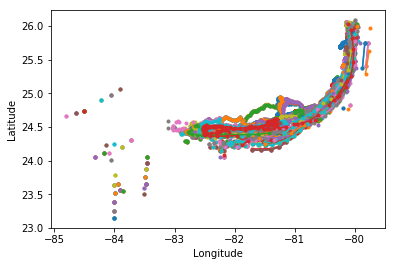

<module 'matplotlib.pyplot' from '/Users/michelleho/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [43]:
plotTrajectoriesFile('release78.nc')

In [18]:
f = Dataset('release78.nc')

# Parsing data

In [45]:
f = Dataset('release78.nc')


In [94]:
f.dimensions

OrderedDict([(u'obs',
              <type 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'obs', size = 313),
             (u'trajectory',
              <type 'netCDF4._netCDF4.Dimension'>: name = 'trajectory', size = 273)])

In [ ]:
lat = f.variables['lat'][:]
lon = f.variables['lon'][:]
time_var = f.variables['time']
dtime = netCDF4.num2date(time_var[:],time_var.units)
precip = nc.variables['precip'][:]

# a pandas.Series designed for time series of a 2D lat,lon grid
precip_ts = pd.Series(precip, index=dtime) 

precip_ts.to_csv('precip.csv',index=True, header=True)

In [95]:
# restructure the data from NC file to Dataframe
f = Dataset('release78.nc')

newdata = []
for n, idx in enumerate(f.variables['trajectory'][:]):
    for i, t in enumerate(f.variables['time'][:][0]):
        newdata.append([n, t, 
                        f.variables['lat'][:][n, i], 
                        f.variables['lon'][:][n, i]])
df = pd.DataFrame.from_records(newdata, columns=['idx', 'time', 'lat', 'lon'])

In [96]:
df.head()

,idx,time,lat,lon
0,0,3.34515e+09,24.99,-80.37
1,0,--,--,--
2,0,3.34519e+09,25.3157,-80.1642
3,0,3.34521e+09,25.4517,-80.1226
4,0,--,--,--


In [97]:
df.time.iloc[2]

3345192000.0

# Settlement Behavior

In [22]:
# Credentials hidden
cc = cartoframes.CartoContext()

In [23]:
cc.write(df,'trajectories_preliminary', lnglat=('lon','lat'), overwrite=True)

/Users/michelleho/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/trajectories_preliminary
`the_geom` column is being populated from `('lon', 'lat')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), '8a562089-1b9a-4b29-b867-8d494705e85d').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


BatchJobStatus(job_id='8a562089-1b9a-4b29-b867-8d494705e85d', last_status='pending', created_at='2018-08-02T19:53:19.395Z')

In [26]:
release_locations = pd.read_csv('florida_currents/release_FL.csv', header=None, names=['code','latitude','longitude'])

In [27]:
cc.write(release_locations, 'fl_release_sites', overwrite=True)

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/fl_release_sites


In [78]:
day0 = 3345148800.0
day30 = day0 + (60 * 60 * 24 * 30)

In [ ]:
day30 = 

In [ ]:
settled_idx_query = '''
WITH day31 AS (SELECT idx, the_geom, the_geom_webmercator FROM trajectories_preliminary WHERE time = '35337600.0')
SELECT distinct(day45.idx)
FROM day31 INNER JOIN release_sites ON ST_Intersects(day45.the_geom_webmercator, ST_Buffer(ST_transform(ST_SetSRID(release_sites.the_geom,4326),3857), 5))
'''

In [ ]:
settled_idx = cc.query(settled_idx_query)

# Map trajectories with basemap

In [ ]:
pfile = Dataset('ReefRelease_45days.nc', 'r')

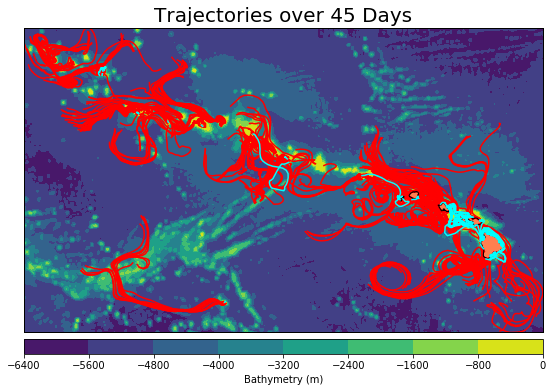

In [177]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

pfile = Dataset('ReefRelease_45days.nc', 'r')
bath_data = Dataset('../HAWc0.04_depth.cdf')

lon = pfile.variables['lon']
lat = pfile.variables['lat']
idx = pfile.variables['trajectory']

# Set up the figure, change figsize as needed
plt.figure(figsize=(12,6))

# Set up mapper with a Basemap of coastal boundaries for Hawaii
mapper = Basemap(projection='merc',
                 llcrnrlon=360+np.nanmin(lon),
                 llcrnrlat=15.272645,
                 urcrnrlon=360+np.nanmax(lon),
                 urcrnrlat=29.9139,
                 resolution='i')
mapper.drawmapboundary()
mapper.drawcoastlines()
mapper.fillcontinents(color='coral',lake_color='aqua')


# plot each trajectory separately, in gold color
# documentation: https://matplotlib.org/basemap/index.html
for i, value in enumerate(idx):
    lons = lon[:][i]
    lats = lat[:][i]
    if i in settled_idx.idx.values:
        color = 'cyan'
        zorder = 2
    else:
        color = 'red'
        zorder = 1
    mapper.plot(np.array(lons), np.array(lats), latlon=True, color=color, zorder=zorder)

# Set up processing for bathymetry data
lats = bath_data.variables['Y_B'][:]
lons = bath_data.variables['X_B'][:]
BATHY_OUT = bath_data.variables['BATHY_OUT'][:] # etopo1 bedrock global relief model-topography/bathymetry (m)

lons,lats= np.meshgrid(lons,lats)
x,y = mapper(lons,lats)

# Create contour object and add to the mapper
depth = mapper.contourf(x,y,BATHY_OUT[0])

# plot release sites

# Add legend
cb = mapper.colorbar(depth,"bottom", size="5%", pad="2%")
cb.set_label('Bathymetry (m)')

# Change plot titles
plt.title('Trajectories over 45 Days', fontsize=20)
plt.savefig('Trajectories_45_Settlement.png')

plt.show()

# FIGURE 2

Figure 2. Connectivity patterns throughout the Hawaiian Archipelago and offshore waters from the 687 release coral reef habitats (red dots) (Weiss, 2009). Lines represent connections, not dispersal trajectories. Their thickness (or color?) is proportional to the intensity of the connections.

In [179]:
release_locations = pd.read_csv('ReefCellData_for_Johanna_23June2014.csv', header=None, names=['value','name','code','latitude','longitude'])
lat = release_locations['latitude']
lon = release_locations['longitude']

In [180]:
npart = 10
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle,
                   lon=np.tile(lon,npart), lat=np.tile(lat,npart), time=march_1)

In [182]:
def turbVal(particle, fieldset, time, dt):
    # This if-statement is meant to trigger when the current time is a quarter interval of the model timestep
    # but I'm not sure it's working... need to double-check
    if math.fmod(time,dt/4) == 0:
        horDiff = 100
        uturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1) # Important! Should this be random.random()???
        # should set random seed somewhere too...?
        particle.lat += uturb * dt/1.1e5
        vturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1)
        particle.lon += vturb * dt/1.1e5
k_turbVal = pset.Kernel(turbVal)        # casting the turbVal function to a kernel object

In [183]:
# Advect the particles, single release repeated n times, for 45 days with dt 1 day with turbulence
pset.execute(AdvectionRK4 + k_turbVal,
             runtime=timedelta(days=45), # runtime controls the interval of the plots
             dt=timedelta(days=1),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=pset.ParticleFile(name="ReefRelease_turb_{}npart_45days_2".format(npart), outputdt=timedelta(days=1)))  # the file name and the time step of the outputs) 

INFO: Compiled JITParticleAdvectionRK4turbVal ==> /var/folders/nj/pymsyw7n28qdntb958tl337c0000gp/T/parcels-502/904e7e2be9e0aace464c4e34ec97fc79.so


In [ ]:
plotTrajectoriesFile('ReefRelease_turb_{}npart_45days_2.nc'.format(npart))

KeyboardInterrupt: 

In [2]:
npart=100
f = Dataset('ReefRelease_turb_{}npart_45days_2.nc'.format(npart))

In [3]:
day45 = 35337600.0 # aka the last timestamp

In [9]:
f.variables['time'][1000]

masked_array(data=[31449600.0, 31536000.0, 31622400.0, 31708800.0,
                   31795200.0, 31881600.0, 31968000.0, 32054400.0,
                   32140800.0, 32227200.0, 32313600.0, 32400000.0,
                   32486400.0, 32572800.0, 32659200.0, 32745600.0,
                   32832000.0, 32918400.0, 33004800.0, 33091200.0,
                   33177600.0, 33264000.0, 33350400.0, 33436800.0,
                   33523200.0, 33609600.0, 33696000.0, 33782400.0,
                   33868800.0, 33955200.0, 34041600.0, 34128000.0,
                   34214400.0, 34300800.0, 34387200.0, 34473600.0,
                   34560000.0, 34646400.0, 34732800.0, 34819200.0,
                   34905600.0, 34992000.0, --, --, --, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False

In [30]:
# Number of particles released
len(set(f.variables['trajectory']))

68700

In [97]:
f.variables['time'].shape

(3435, 46)

In [19]:
f.variables['time'][:,-5]

array([34992000., 34992000., 34992000., ..., 34992000., 34992000.,
       34992000.])

In [20]:
day45_lon = f.variables['lon'][:,-5]
day45_lat = f.variables['lat'][:,-5]

day1_lon = f.variables['lon'][:,0]
day1_lat = f.variables['lat'][:,0]

In [21]:
df = pd.DataFrame(data=[day1_lat,day1_lon, day45_lat, day45_lon]).T

In [22]:
df.columns = ['day1_lat','day1_lon', 'day45_lat', 'day45_lon']

In [23]:
df = df.astype('float')

In [24]:
df.head()

,day1_lat,day1_lon,day45_lat,day45_lon
0,28.501778,-178.369614,28.537651,-177.050308
1,28.501778,-178.261810,28.546841,-177.907013
2,28.470032,-178.369614,28.473461,-176.266800
3,28.470032,-178.261810,28.678768,-179.028610
4,28.438274,-178.369614,28.745375,-176.634705


In [25]:
cc = cartoframes.CartoContext()

In [26]:
cc.write(df, 'day45_position_{}n'.format(npart), lnglat=('day45_lon','day45_lat'), overwrite=True)

/Users/mho/anaconda3/envs/py2_parcels/lib/python2.7/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/day45_position_100n
`the_geom` column is being populated from `('day45_lon', 'day45_lat')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), '4c807061-57bc-408f-a73e-9d0f6d1fd18d').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


BatchJobStatus(job_id='4c807061-57bc-408f-a73e-9d0f6d1fd18d', last_status='pending', created_at='2018-05-04T16:02:12.543Z')

In [34]:
cartoframes.BatchJobStatus(cc, '4c807061-57bc-408f-a73e-9d0f6d1fd18d').status()

{'created_at': u'2018-05-04T16:02:12.543Z',
 'status': u'done',
 'updated_at': u'2018-05-04T16:03:46.735Z'}

In [157]:
# For each particle, find the nearest polygon at day 45

find_the_nearest_settlement_polygon = '''
WITH day45 AS (SELECT cartodb_id, idx, the_geom, the_geom_webmercator FROM trajectories_5n WHERE time = 35337600),
closest_polygon AS (SELECT
  particle_location.cartodb_id,
  particle_location.idx,
  particle_location.the_geom,
  particle_location.the_geom_webmercator,
  settlement_polygon.cartodb_id as settlement_id,
ST_Distance(geography(settlement_polygon.the_geom), geography(particle_location.the_geom), false) AS distance
FROM
  day45 AS particle_location
CROSS JOIN LATERAL
  (SELECT *
   FROM release_sites
   ORDER BY
     particle_location.the_geom_webmercator <-> the_geom_webmercator
   LIMIT 1) AS settlement_polygon)
SELECT * from closest_polygon
WHERE distance < 5000
'''

In [35]:
# For each particle, find the nearest polygon at day 45 (FOR REPEATED)

find_the_nearest_settlement_polygon_n = '''
WITH closest_polygon AS (SELECT
  particle_location.cartodb_id,
  particle_location.day1_lat,
  particle_location.day1_lon,
  particle_location.the_geom,
  particle_location.the_geom_webmercator,
  settlement_polygon.cartodb_id as settlement_id,
  ST_Distance(geography(settlement_polygon.the_geom), geography(particle_location.the_geom), false) AS distance
    FROM
  day45_position_{}n AS particle_location
    CROSS JOIN LATERAL
      (SELECT *
       FROM release_sites
       ORDER BY
         particle_location.the_geom_webmercator <-> the_geom_webmercator
       LIMIT 1) AS settlement_polygon)
SELECT * from closest_polygon
WHERE distance < 5000
'''

In [36]:
cc = cartoframes.CartoContext()

In [37]:
connectivity_output = cc.query(find_the_nearest_settlement_polygon_n.format(npart),
                               table_name = 'connectivity_output_{}n'.format(npart))

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/connectivity_output_100n


In [38]:
aggregate_connectivity = '''
SELECT day1_lat, day1_lon, settlement_id, count(*) FROM connectivity_output_{}n
GROUP BY day1_lat, day1_lon, settlement_id
ORDER BY count DESC
'''

In [39]:
aggregate_connectivity = cc.query(aggregate_connectivity.format(npart),
                                  table_name = 'aggregate_connectivity_{}n'.format(npart))

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/aggregate_connectivity_100n


In [41]:
release_locations.head()

,value,name,code,latitude,longitude
0,0.066875,Kure Atoll,NOAA NCCOS,28.501778,-178.369614
1,0.015000,Kure Atoll,NOAA NCCOS,28.501778,-178.261817
2,0.115000,Kure Atoll,NOAA NCCOS,28.470031,-178.369614
3,0.237500,Kure Atoll,NOAA NCCOS,28.470031,-178.261817
4,0.266250,Kure Atoll,NOAA NCCOS,28.438274,-178.369614


In [42]:
cc.write(release_locations, 'release_sites_original', lnglat = ('longitude','latitude'))

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/release_sites_original


In [ ]:
origin_time = 31449600

In [165]:
make_lines_aggcount = '''
SELECT row_number() OVER () As cartodb_id, ST_MAKELINE(s.the_geom, d.the_geom) as the_geom,
      ST_Transform(ST_MAKELINE(s.the_geom, d.the_geom), 3857) as the_geom_webmercator,
      s.cartodb_id origin_id, d.cartodb_id dest_id, sum(count)
FROM release_sites_original  s, release_sites_original d , (select * from aggregate_connectivity_5n) data_table
WHERE s.latitude = data_table.day1_lat AND s.longitude = data_table.day1_lon AND d.cartodb_id = data_table.settlement_id
group by ST_MAKELINE(s.the_geom, d.the_geom), s.cartodb_id + d.cartodb_id, s.cartodb_id, d.cartodb_id
'''

In [40]:
make_lines_aggcount_WITH_ORIGIN_LAT_LON = '''
SELECT row_number() OVER () As cartodb_id, ST_MAKELINE(ST_SetSRID(ST_POINT(data_table.day1_lon,data_table.day1_lat),4326), d.the_geom) as the_geom,
      ST_Transform(ST_MAKELINE(ST_SetSRID(ST_POINT(data_table.day1_lon,data_table.day1_lat),4326), d.the_geom), 3857) as the_geom_webmercator,
      sum(data_table.count)
FROM release_sites_original  d, (select * from aggregate_connectivity_{}n) data_table
WHERE d.cartodb_id = data_table.settlement_id
group by ST_MAKELINE(ST_SetSRID(ST_POINT(data_table.day1_lon,data_table.day1_lat),4326), d.the_geom)
'''

In [41]:
cc.query(make_lines_aggcount_WITH_ORIGIN_LAT_LON.format(npart), 'connectivity_lines_{}n'.format(npart))

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/connectivity_lines_100n


,sum,the_geom
cartodb_id,,
1,1,0105000020E61000000100000001020000000200000000...
2,1,0105000020E61000000100000001020000000200000000...
3,1,0105000020E61000000100000001020000000200000000...
4,1,0105000020E61000000100000001020000000200000000...
5,1,0105000020E61000000100000001020000000200000000...
6,1,0105000020E61000000100000001020000000200000000...
7,1,0105000020E61000000100000001020000000200000000...
8,1,0105000020E61000000100000001020000000200000000...
9,1,0105000020E61000000100000001020000000200000000...


In [ ]:
# Remaining styling done in CARTO.